# 🦒 Running Deep Learning Models with BioEngine ⚙️☁️

Welcome to this tutorial! We'll guide you through running image analysis models from [BioImage.IO](https://bioimage.io) using the BioEngine server.

We'll show you how to:
1. Load an image,
2. Reshape it according to each model's specifications (called `RDF` – a metadata format describing the models hosted on [BioImage.IO](https://bioimage.io)),
3. Send the image (as a numpy array) to the BioEngine server to run the models. 🚀

All models showcased are available in the [BioImage.IO Model Zoo](https://bioimage.io/#). You can also adapt this tutorial for other models in the zoo! 🧑‍🔬

⚠️ **Note:** The data will be sent to a remote server ([https://hypha.bioimage.io](https://hypha.bioimage.io)) run by the AI4Life team. This service is for evaluation purposes only and may change without notice. If you're looking for an on-prem solution (HPC or Kubernetes), check out the deployment guidelines here: [Deployment Toolkits](https://github.com/bioimage-io/bioengine/tree/main?tab=readme-ov-file#deployment-toolkits).

If you're using your own instance, be sure to update the server URL (`https://hypha.aicell.io`) and the BioEngine service ID (`bioimage-io/bioengine-apps`) accordingly. 🔧

## Installation and module imports

In [ ]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["hypha-rpc", "kaibu-utils", "pyodide-http", "requests"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "kaibu-utils", "matplotlib"])

import io
import json

import matplotlib.pyplot as plt
import numpy as np
from hypha_rpc import connect_to_server, login
from kaibu_utils import fetch_image
from PIL import Image

In [ ]:
# Server URL: For this workshop we will use the hypha.aicell.io server
SERVER_URL = "https://hypha.aicell.io"

In [22]:
MODEL_ID = "affable-shark"

# Running UNet membrane segmentation model via the BioEngine

### Download an example image

Example image downloaded: (256, 256)


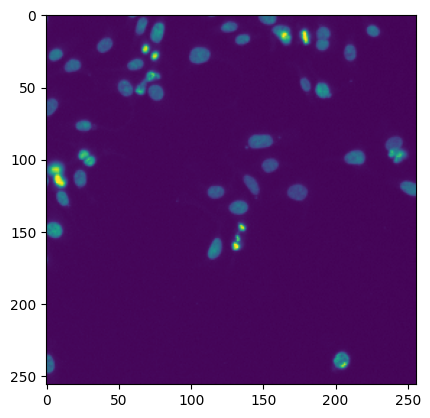

In [ ]:
image = await fetch_image(
    f"https://hypha.aicell.io/bioimage-io/artifacts/{MODEL_ID}/files/sample_input_0.tif"
)
image = image.astype("float32")
print(f"Example image downloaded: {image.shape}")
plt.imshow(image)
plt.show()

### Connect to the server

In [8]:
token = await login({"server_url": SERVER_URL})
server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token, "method_timeout": 3000}
)

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=tddbEwr38nyUdBiiWeDp2b


### Access the BioEngine deployments

A public BioEngine instance is available with the service ID `bioimage-io/bioengine-apps`

In [9]:
PUBLIC_BIOENGINE = "ws-user-github|49943582/bioengine-apps"

bioengine = await server.get_service(PUBLIC_BIOENGINE)

If you have started your own BioEngine instance, you can first list your deployment services and then 

In [10]:
services = await server.list_services({"type": "bioengine-apps"})

for service in services:
    print(f"BioEngine apps service ID: {service.id}")

if len(services) == 0:
    print("No BioEngine apps service available.")

BioEngine apps service ID: ws-user-github|49943582/9DSxsheFzjgn6qCoZH8fLB:bioengine-apps


In [ ]:
PRIVATE_BIOENGINE = "<your-private-bioengine-service-id>"

bioengine = await server.get_service(PRIVATE_BIOENGINE)

### View the RDF

This helps to verify the expected input format and other model details

In [ ]:
model_rdf = await bioengine.bioimage_io_model_runner.get_model_rdf(
    model_id="affable-shark"
)
print(json.dumps(model_rdf, indent=4))

{
    "name": "NucleiSegmentationBoundaryModel",
    "description": "Nucleus segmentation for fluorescence microscopy",
    "covers": [
        "cover.png"
    ],
    "id_emoji": "\ud83e\udd88",
    "authors": [
        {
            "affiliation": "EMBL Heidelberg",
            "email": null,
            "orcid": null,
            "name": "Constantin Pape",
            "github_user": "constantinpape"
        }
    ],
    "attachments": [
        {
            "source": "zero_mean_unit_variance.ijm",
            "sha256": "767f2c3a50e36365c30b9e46e57fcf82e606d337e8a48d4a2440dc512813d186"
        }
    ],
    "cite": [
        {
            "text": "training library",
            "doi": "10.5281/zenodo.5108853",
            "url": null
        },
        {
            "text": "architecture",
            "doi": "10.1007/978-3-319-24574-4_28",
            "url": null
        },
        {
            "text": "segmentation algorithm",
            "doi": "10.1038/nmeth.4151",
            "ur

### Make sure the input image shape is valid

In [ ]:
input_format = model_rdf["inputs"][0]

input_size = {}
for axis in input_format["axes"]:
    if axis["id"] == "y":
        input_size["y"] = dict(axis["size"])
    if axis["id"] == "x":
        input_size["x"] = dict(axis["size"])
print(f"Required input size: {input_size}")

input_image_shape = image.shape[:2]
print("Image shape:", input_image_shape)

image_x_size = input_image_shape[1]
image_y_size = input_image_shape[0]
assert (
    image_x_size >= input_size["x"]["min"]
    and image_x_size % input_size["x"]["step"] == 0
), f"Wrong image x size ({image_x_size}), expected: {input_size['x']['min']} and multiple of {input_size['x']['step']}"
assert (
    image_y_size >= input_size["y"]["min"]
    and image_y_size % input_size["y"]["step"] == 0
), f"Wrong image y size ({image_y_size}), expected: {input_size['y']['min']} and multiple of {input_size['y']['step']}"

print("Valid image shape, ready to go!")

Required input size: {'y': {'min': 64, 'step': 16}, 'x': {'min': 64, 'step': 16}}
Image shape: (256, 256)
Valid image shape, ready to go!


The model's preprocessing will ensure the right data type and normalization.

In [29]:
print(json.dumps(input_format["preprocessing"], indent=4))

[
    {
        "id": "ensure_dtype",
        "kwargs": {
            "dtype": "float32"
        }
    },
    {
        "id": "zero_mean_unit_variance",
        "kwargs": {
            "axes": [
                "channel",
                "y",
                "x"
            ],
            "eps": 1e-06
        }
    },
    {
        "id": "ensure_dtype",
        "kwargs": {
            "dtype": "float32"
        }
    }
]


## Make prediction with the BioEngine

In [ ]:
input_format = model_rdf["inputs"][0]
input_key = input_format["id"]
inputs = {input_key: image}

output_format = model_rdf["outputs"][0]
output_key = output_format["id"]

result = await bioengine.bioimage_io_model_runner.infer(
    model_id="affable-shark", inputs=inputs
)
mask = result[output_key]
print("prediction:", mask.shape)

prediction: (1, 2, 256, 256)


## Display the segmentation result

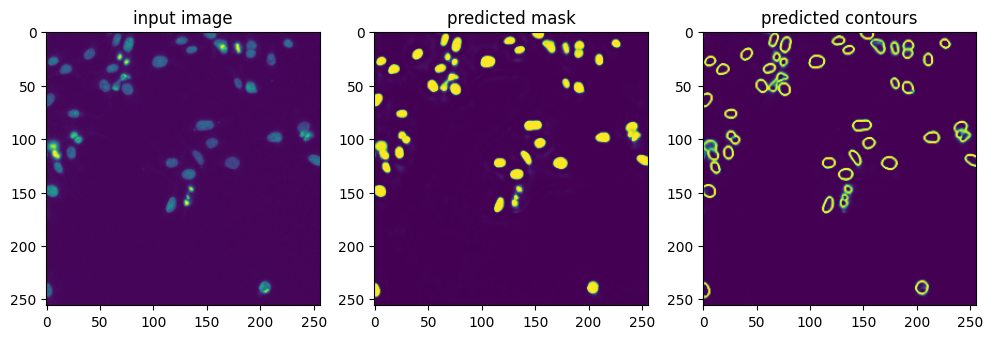

In [ ]:
# display the output
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(image.astype("uint8"))
ax1.set_title("input image")
ax2.imshow(mask[0, 0])
ax2.set_title("predicted mask")
ax3.imshow(mask[0, 1])
ax3.set_title("predicted contours")
plt.show()

# Running Stardist nuclei segmentation via the BioEngine

prediction:  (1, 512, 512, 33)
Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist


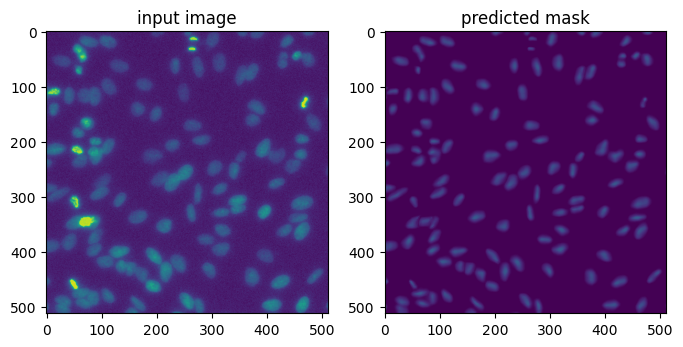

In [ ]:
# obtain the model config
image = await fetch_image(
    "https://raw.githubusercontent.com/stardist/stardist/3451a4f9e7b6dcef91b09635cc8fa78939fb0d29/stardist/data/images/img2d.tif",
    grayscale=True,
)
image = image.astype("uint16")
param = {"diameter": 30}

# run inference
ret = await triton.execute(
    inputs=[{"inputs": [[image[..., None]]], "model_id": "fearless-crab"}],
    model_name="bioengine-model-runner",
    serialization="imjoy",
)
result = ret["result"]
mask = result["outputs"][0]
print("prediction: ", mask.shape)
print(
    "Note: use the stardist library to properly post-process this output! https://github.com/stardist/stardist"
)

# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image)
ax1.set_title("input image")
ax2.imshow(mask[0, :, :, 0])
ax2.set_title("predicted mask")
plt.show()

** Note: The above model doesn't run the stardist post-processing, so you will get many output channels as output from the U-Net model.

## Trying more models in BioImage.IO

Feel free to find more models at https://bioimage.io, if you want to run a model, please do the following as shown above:
 - Copy the animal nickname id in the model card
 - Print the RDF information so you know what's the expected input shape
 - Load your image, and make sure you reshape or resize it according to the expected input shape using numpy or scikit-image etc.
 - Run the model via `execute`, by passing the model id, image
 - Get the result, extract the image for display according to the output shape according to the RDF.


## Hosting your own BioEngine

While the above demos uses our public free BioEngine server, you can also launch your own bioengine server on a GPU workstation or HPC, and connect to your own BioEngine instance by switching the server URL. If you are interested please following the deployment guidelines here: [Deployment Toolkits](https://github.com/bioimage-io/bioengine/tree/main?tab=readme-ov-file#deployment-toolkits).

If you're using your own instance, be sure to update the server URL (`https://hypha.bioimage.io`) and the Triton service ID (`triton-client`) accordingly.

Please note that the deployment is in early stage, so please if you have any issue or trouble in setting it up, please don't hesitate to reach out via email, forum, web form or github issues: https://github.com/bioimage-io/bioengine/issues

